## 5주차 과제 복습

> owid covid-19 데이터에 대해 대한민국을 포함한 5개 국가에 대해 년도를 선택하면 해당 년도의 신규확진자 수 그래프를 그려주는 웹을 만들어보세요

```
import pandas as pd
import streamlit as st
import plotly.express as px
from functools import reduce

st.write("""
# Data Analysis Dash Board 
> programmed by 박종관, Modified by 정석용
""")

raw_data = pd.read_csv('owid-covid-data.csv')
revised_data = raw_data[['iso_code', 'location', 'date', 'new_cases', 'population']].copy()
revised_data['date'] = pd.to_datetime(revised_data['date'])
revised_data['year'] = revised_data['date'].dt.year
revised_data['month'] = revised_data['date'].dt.month

# 연도 데이터 추출하여 리스트로 저장
year = revised_data['year'].unique().tolist()
# 국가 이름 추출하여 리스트로 저장
countries = revised_data['location'].unique().tolist()


st.sidebar.title('Sidebar')

# multi selelct
select_country = st.sidebar.multiselect('나라를 선택하시오. 복수 선택 가능', countries)

# radio box
select_year = st.sidebar.radio('연도를 선택하시오', year, horizontal=True)

# slide bar 생성
select_range = st.sidebar.slider("원하는 월을 선택하시오", min_value=1, max_value=12, value=(1, 12))
start_month, end_month = select_range

# filter start button
start = st.sidebar.button('filter apply')

if start:
    tmp_df = revised_data[revised_data['year'] == select_year]
    
    country_df_list = []
    country_list = []
    for i in select_country :
        globals()[f'{i}_total'] = tmp_df.query(f'(location == "{i}") & (month >= @start_month) & (month <= @end_month)')[['date', 'new_cases']]
        globals()[f'{i}_total'] = globals()[f'{i}_total'][['date', 'new_cases']].rename(columns={'new_cases': i})
        country_df_list.append(globals()[f'{i}_total'])
        country_list.append(i)
                  
    final_df = reduce(lambda x,y: pd.merge(x,y, on='date', how='outer'), country_df_list)                  

    fig = px.line(
        final_df,
        x='date',
        y=country_list,
        title='나라별 신규 확진자 수'
    )
    st.plotly_chart(fig)

    st.sidebar.success('filter apply success')
    st.balloons()
```

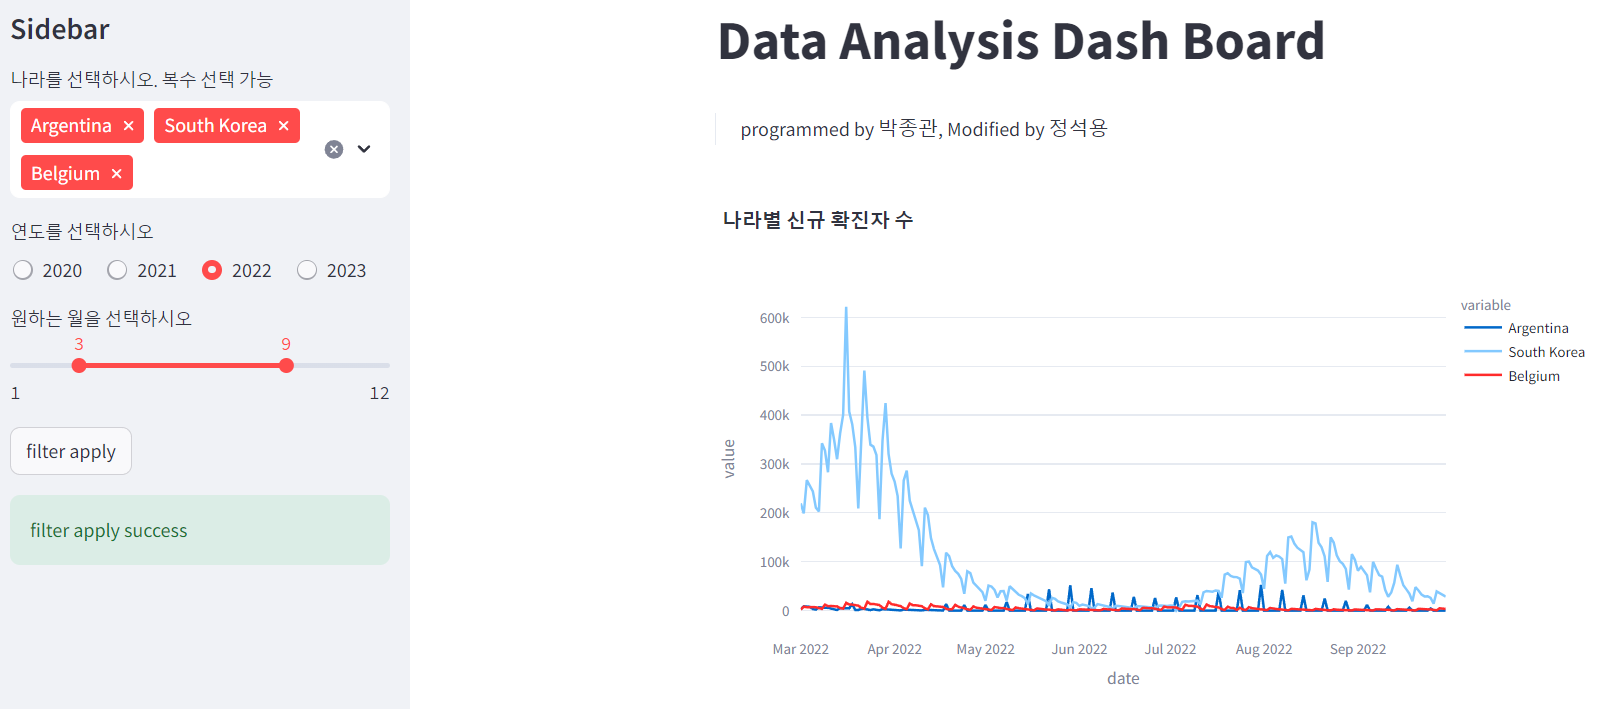

## Lab 1

## 1. 문제 정의

1. 지하철에서 가볍게 식사할 수 있는 음식 관련 사업을 준비하고 있습니다.
2. 사업 아이디어가 괜찬은지 검증하고 싶어 가장 유동인구가 많은 지하철역 몇군데에서 음식을 팔아보려고 합니다.
3. 서울 출퇴근 시간에 가장 유동인구가 많은 지하철역 3군데를 선택하려고합니다.
4. 신뢰도를 높이기 위해 유동인구를 알아보기 쉽게 표기한 그래프를 준비하려고 합니다. 

### 2. 지도 라이브러리(Folium) 설치하기

In [ ]:
# 지도 라이브러리(Folium) 설치
!pip install folium

In [ ]:
# 지도 라이브러리(Folium) 설치 확인
!pip list folium

In [ ]:
# 지도 라이브러리(Folium) 설치 확인
import folium

# 기본 서울지도 그리기
seoul = folium.Map(location=[37.55, 126.98], zoom_start = 12)
seoul

### 2. 데이터 수집

### 2.1 서울시 공공 데이터
> 서울 열린 데이터 광장 홈페이지 https://data.seoul.go.kr/
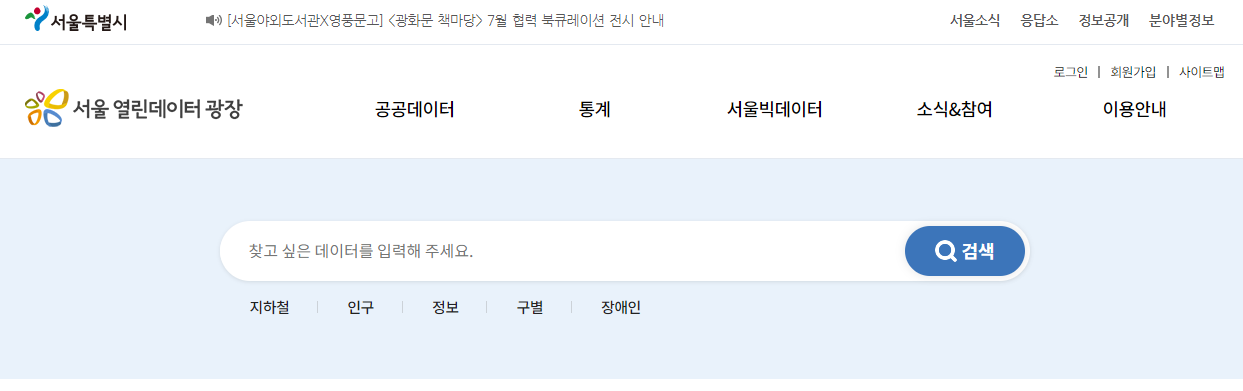
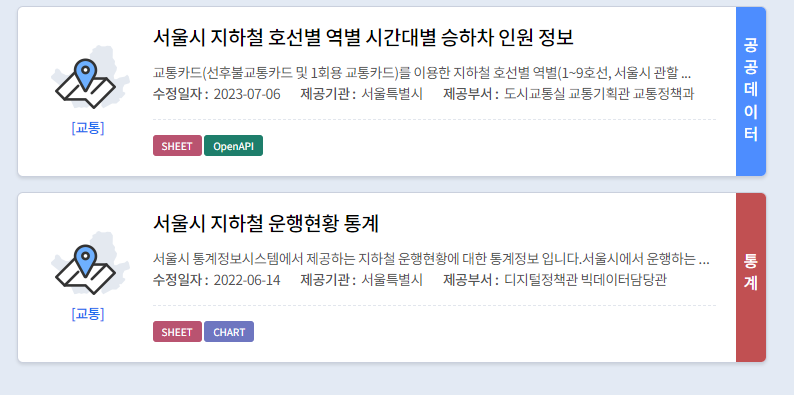

### 2.2 캐글(Kaggle) 데이터
> 전 세게에서 가장 큰 데이터 과학 커뮤니티(https://kaggle.com)

> 검색 : 'seoul metro Usage'

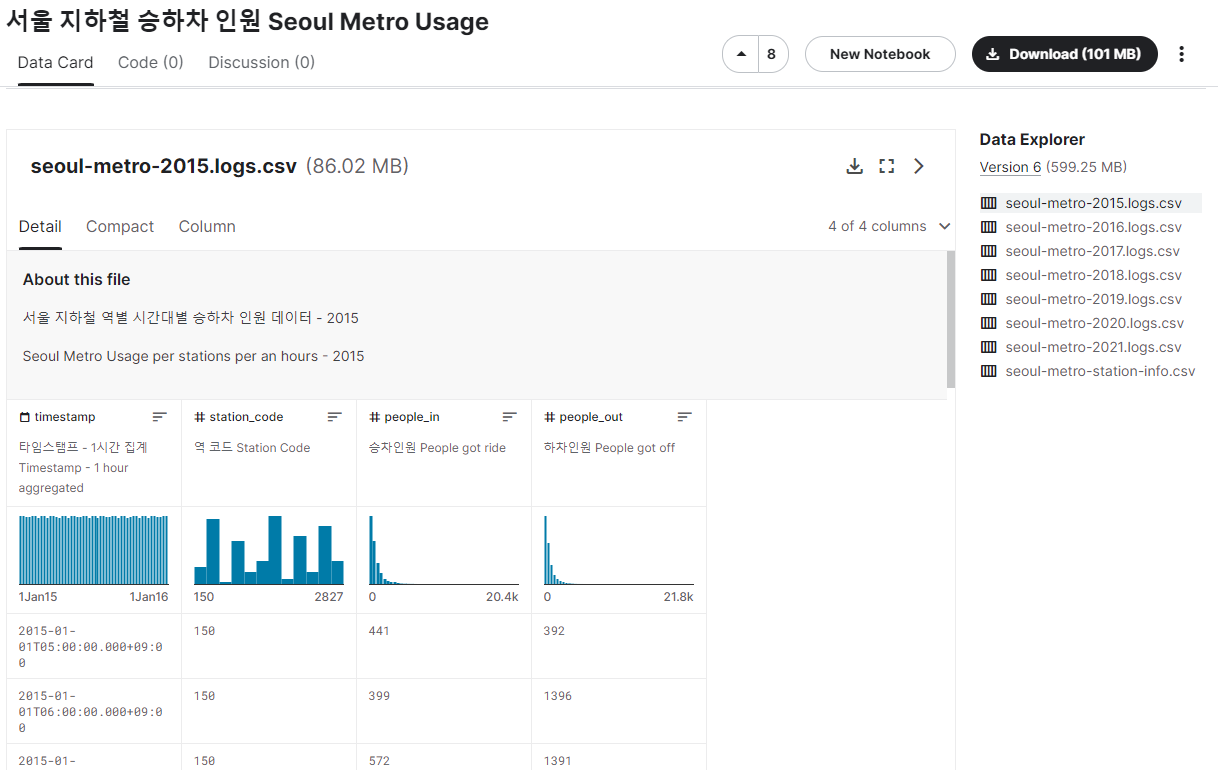

### 2.2.1 캐글(Kaggle) 데이터 다운로드
1. 시간대별 승하차 인원 데이터 (seoul-metro-2021.logs.csv)
2. 지하철역 관련 정보 (seoul-metro-station-info.csv)


In [14]:
import pandas as pd

# 서울 지하철 시간대별 승하차 인원 데이터 읽어오기
data = pd.read_csv('seoul-metro-2021.logs.csv')

data.head()

,timestamp,station_code,people_in,people_out
0,2021-01-01T05:00:00.000+09:00,150,86,85
1,2021-01-01T06:00:00.000+09:00,150,111,355
2,2021-01-01T07:00:00.000+09:00,150,157,438
3,2021-01-01T08:00:00.000+09:00,150,306,592
4,2021-01-01T09:00:00.000+09:00,150,333,841


In [2]:
# 서울 지하철 역 정보 데이터 읽어오기
station_info = pd.read_csv('seoul-metro-station-info.csv')

station_info.head()

,station.code,station.fr_code,line.num,line.name,line.name_sub,line.station_seq,station.name_full,station.name,station.name_chc,station.name_chn,station.name_en,station.name_jp,geo.latitude,geo.longitude,geo.sigungu_code,geo.sigungu_name,geo.addres_road,geo.address_land,geo.phone
0,158,124,1,1호선,지하철1호선,1,청량리(서울시립대입구),청량리|서울시립대입구,祭基洞,祭基洞,Jegidong,チェギドン,37.580178,127.046835,11060,동대문구,서울특별시 동대문구 왕산로 지하205(전농동),서울특별시 동대문구 전농동 620-69 청량리역(1호선),02-6110-1241
1,157,125,1,1호선,지하철1호선,2,제기동,제기동,新設洞,新设洞,Sinseoldong,シンソルトン,37.578103,127.034893,11060,동대문구,서울특별시 동대문구 왕산로 지하93(제기동),서울특별시 동대문구 제기동 65 제기동역(1호선),02-6110-1251
2,156,126,1,1호선,지하철1호선,3,신설동,신설동,東廟앞,东庙,Dongmyo,トンミョアプ,37.575297,127.025087,11060,동대문구,서울특별시 동대문구 왕산로 지하1(신설동),서울특별시 동대문구 신설동 76-5 신설동역(1호선),02-6110-1261
3,159,127,1,1호선,지하철1호선,4,동묘앞,동묘앞,淸凉里(서울市立大入口),清凉里(首尔市立大学),Cheongnyangni(University of Seoul),チョンニャンニ,37.572627,127.016429,11010,종로구,서울특별시 종로구 종로 359(숭인동),서울특별시 종로구 숭인동 117 동묘앞역(1호선),02-6110-1271
4,155,128,1,1호선,지하철1호선,5,동대문,동대문,東大門,东大门,Dongdaemun,トンデムン,37.571420,127.009745,11010,종로구,서울특별시 종로구 종로 지하302(창신동),서울특별시 종로구 창신동 492-1 동대문역(1호선),02-6110-1281


### 3. 데이터 가공-1


In [3]:
# 승차인원 데이터 상세 정보 확인하기
# timestamp : 시간
# station_code : 역 코드
# people_in : 승차인원
# people_out : 하차인원

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941553 entries, 0 to 1941552
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   timestamp     object
 1   station_code  int64 
 2   people_in     int64 
 3   people_out    int64 
dtypes: int64(3), object(1)
memory usage: 59.3+ MB


In [4]:
# 역 기준으로 승차인원 합치기
# 숫자 타입이 아닌 timestamp는 사라짐
station_sum = data.groupby('station_code')[['people_in', 'people_out']].sum()
station_sum

,people_in,people_out
station_code,,
150,12697273,12109991
151,5997344,6030491
152,9638952,9284693
153,7704599,7090896
154,6651283,6609055
...,...,...
2824,3206211,3097722
2825,1395919,1495603
2826,1614590,1475010


In [5]:
# 지하철 역 데이터 상세 정보 확인하기
# station.code : 역 코드
# geo.latitude : 지하철 역 위도
# geo.longitude : 지하철역 경도

station_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station.code       285 non-null    int64  
 1   station.fr_code    285 non-null    object 
 2   line.num           285 non-null    int64  
 3   line.name          285 non-null    object 
 4   line.name_sub      285 non-null    object 
 5   line.station_seq   285 non-null    int64  
 6   station.name_full  285 non-null    object 
 7   station.name       285 non-null    object 
 8   station.name_chc   285 non-null    object 
 9   station.name_chn   285 non-null    object 
 10  station.name_en    285 non-null    object 
 11  station.name_jp    285 non-null    object 
 12  geo.latitude       285 non-null    float64
 13  geo.longitude      285 non-null    float64
 14  geo.sigungu_code   285 non-null    int64  
 15  geo.sigungu_name   285 non-null    object 
 16  geo.addres_road    285 non

In [13]:
station_info.head()

,geo.latitude,geo.longitude
station.code,,
158,37.580178,127.046835
157,37.578103,127.034893
156,37.575297,127.025087
159,37.572627,127.016429
155,37.571420,127.009745


In [6]:
# 필요한 변수만 고르기

station_info = station_info[['station.code', 'geo.latitude', 'geo.longitude']]
station_info

,station.code,geo.latitude,geo.longitude
0,158,37.580178,127.046835
1,157,37.578103,127.034893
2,156,37.575297,127.025087
3,159,37.572627,127.016429
4,155,37.571420,127.009745
...,...,...,...
280,2823,37.451535,127.159816
281,2824,37.445210,127.156866
282,2825,37.440918,127.147564
283,2826,37.437428,127.140722


In [7]:
# 승하차 데이터와 색인 맞추기
station_info = station_info.set_index('station.code')
station_info

,geo.latitude,geo.longitude
station.code,,
158,37.580178,127.046835
157,37.578103,127.034893
156,37.575297,127.025087
159,37.572627,127.016429
155,37.571420,127.009745
...,...,...
2823,37.451535,127.159816
2824,37.445210,127.156866
2825,37.440918,127.147564


In [8]:
# 승하차 인원 데이터와 지하철역 정보 데이터 합치기
# 색인을 기준으로 데이터 합치기 : join()

joined_data = station_sum.join(station_info)
joined_data

,people_in,people_out,geo.latitude,geo.longitude
station_code,,,,
150,12697273,12109991,37.554648,126.972559
151,5997344,6030491,37.564718,126.977108
152,9638952,9284693,37.570161,126.982923
153,7704599,7090896,37.571607,126.991806
154,6651283,6609055,37.570926,127.001849
...,...,...,...,...
2824,3206211,3097722,37.445210,127.156866
2825,1395919,1495603,37.440918,127.147564
2826,1614590,1475010,37.437428,127.140722


In [12]:
joined_data.sort_values(by='people_in', ascending=False).head(10)[['people_in']]

,people_in
station_code,
222,24426240
216,20585020
230,19321321
232,17582086
239,16594753
220,15435577
234,14817716
219,14492235
228,14480364


### 4. 데이터 시각화


In [ ]:
# 승차 인원 시각화 (승차용 서울지도 만들기)
seoul_in = folium.Map(location=[37.55, 126.98], zoom_start=12)
seoul_in

In [ ]:
# 히트맵 플러그인 모듈 탑재
from folium.plugins import HeatMap

# 히트맵 플러그인 지도에 추가하기
HeatMap(data=joined_data[['geo.latitude', 'geo.longitude','people_in']]).add_to(seoul_in)
seoul_in

# 강남역, 잠실역, 광화문 일대에 승차인원 집중

In [ ]:
# 하차 인원 시각화 (승차용 서울지도 만들기)
seoul_out = folium.Map(location=[37.55, 126.98], zoom_start=12)
seoul_out

# 히트맵 플러그인 지도에 추가하기
HeatMap(data=joined_data[['geo.latitude', 'geo.longitude','people_out']]).add_to(seoul_out)
seoul_out

# 승차인원 히트맵과 큰차이가 나지 않은 것으로 보임
# 출퇴근 시간을 고려하지 않아 생기는 현상으로 추정됨

## Lab 2

### 5. 데이터 가공-2
- 승하차 시간을 반영한 데이터 가공


In [ ]:
# 데이터 상세 정보 확인
data.info()

In [ ]:
# 출근 데이터 추출을 위한 시간 변수 추가
data['hour'] = pd.to_datetime(data['timestamp']).dt.hour
data.head()

In [ ]:
data.info()

In [ ]:
# 출근 데이터 추출 (9시 이전 데이터 추출)
morning_data = data.query('hour < 9')
morning_data

In [ ]:
# 퇴근 데이터 추출 (9시 이전 데이터 추출)
evening_data = data.query('hour > 17')
evening_data

In [ ]:
# 역을 기준으로 그룹화
morning_station_sum = morning_data.groupby('station_code')[['people_in', 'people_out', 'hour']].sum()
morning_station_sum.head()

In [ ]:
# 역을 기준으로 그룹화
evening_station_sum = evening_data.groupby('station_code')[['people_in', 'people_out', 'hour']].sum()
evening_station_sum.head()

In [ ]:
# 역 정보 합치기
morning_joined_data = morning_station_sum.join(station_info)
evening_joined_data = evening_station_sum.join(station_info)

In [ ]:
morning_joined_data.head()

In [ ]:
evening_joined_data.head()

### 출근 시간 승하차 인원 시각화

In [ ]:
# 출근시간 승차 인원 시각화 (승차용 서울지도 만들기)
morning_seoul_in = folium.Map(location=[37.55, 126.98], zoom_start=12)

# 히트맵 플러그인 지도에 추가하기
HeatMap(data=morning_joined_data[['geo.latitude', 'geo.longitude','people_in']]).add_to(morning_seoul_in)
morning_seoul_in


In [ ]:
# 출근시간 하차 인원 시각화 (승차용 서울지도 만들기)
morning_seoul_out = folium.Map(location=[37.55, 126.98], zoom_start=12)

# 히트맵 플러그인 지도에 추가하기
HeatMap(data=morning_joined_data[['geo.latitude', 'geo.longitude','people_out']]).add_to(morning_seoul_out)
morning_seoul_out

### 퇴근 시간 승하차 인원 시각화

In [ ]:
# 퇴근시간 승차 인원 시각화 (승차용 서울지도 만들기)
evening_seoul_in = folium.Map(location=[37.55, 126.98], zoom_start=12)

# 히트맵 플러그인 지도에 추가하기
HeatMap(data=evening_joined_data[['geo.latitude', 'geo.longitude','people_in']]).add_to(evening_seoul_in)
evening_seoul_in

In [ ]:
# 퇴근시간 하차 인원 시각화 (승차용 서울지도 만들기)
evening_seoul_out = folium.Map(location=[37.55, 126.98], zoom_start=12)

# 히트맵 플러그인 지도에 추가하기
HeatMap(data=evening_joined_data[['geo.latitude', 'geo.longitude','people_out']]).add_to(evening_seoul_out)
evening_seoul_out

### 과제-1
1. 11시부터 2시 사이에 승차인원이 가장 많은 3개는 어디인가 ?
2. 11시부터 2시 사이에 하차인원이 가장 많은 3개는 어디인가 ?

### 과제-2
1. 과제 1에서 가공한 데이터를 가지고 히트맵 대신 조건에 맞는 역에 동그라미를 그려보자
2. folium에서 지도에 동그라미를 그리는 클래스는 Circle임
3. 점심시간에 하차인원이 250만명이 넘는 역만 표시
4. 동그라미 테두리는 붉은색, 내부는 붉은색으로 채운다
5. 동그라미 반지름은 하차인원의 0.01%로 그린다.

### 도전 과제 - streamlit으로 웹 배포
1. 승하차 시간대를 선택하여 분석할 수 있도록 제작

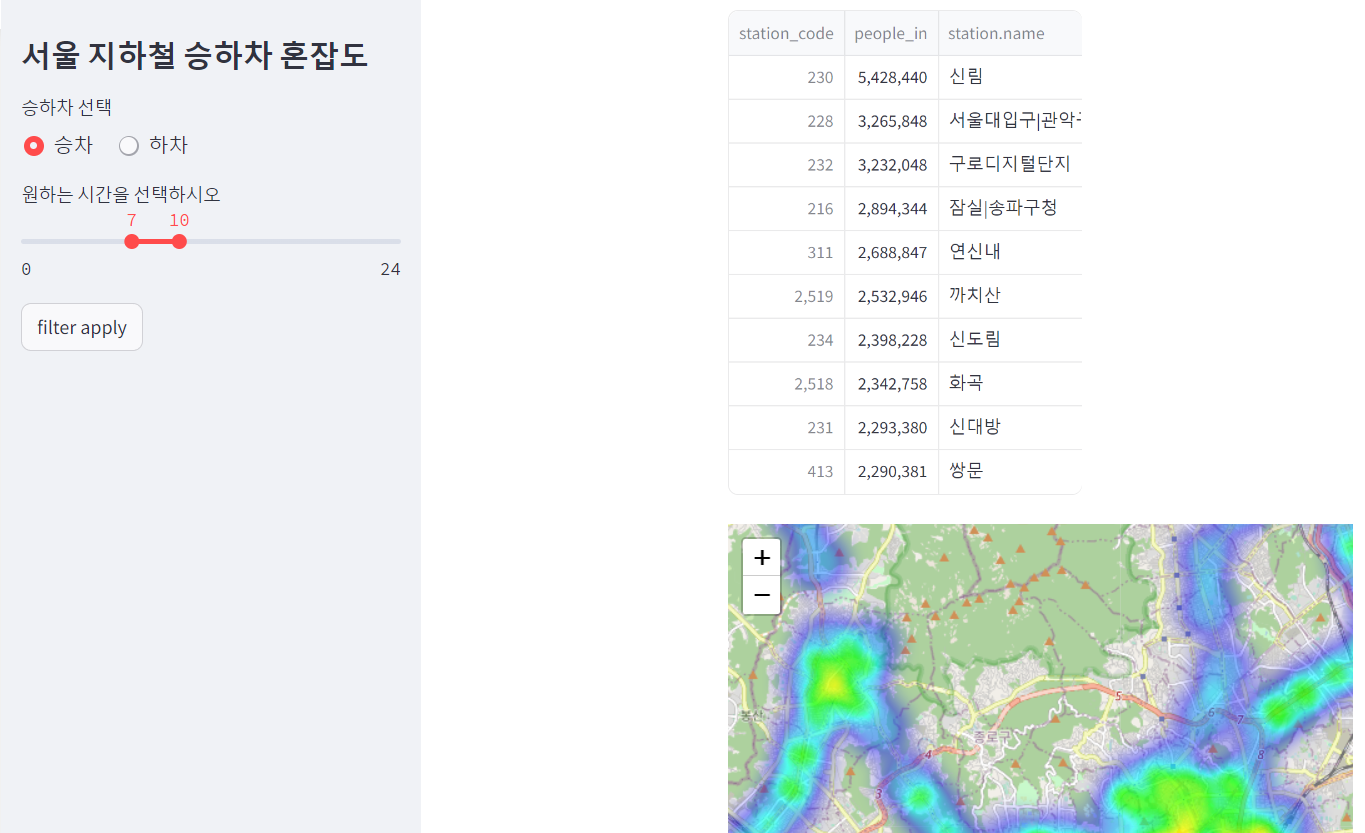